<a href="https://colab.research.google.com/github/lblogan14/PyTorch_tutorial_colab/blob/main/0_Learn_the_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#QUICKSTART

##Working with data
* `torch.utils.data.Dataset` stores the samples and their corresponding labaels.
* `torch.utils.data.DataLoader` wraps an iterable around the `Dataset`.


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as `TorchText`, `TorchVision`, and `TorchAudio`, all of which include `datasets`. The `torchvision.datasets` module contains `Dataset` objects for many real-world vision data like CIFAR, COCO, etc. Every TorchVision `Dataset` includes two arguments: `transform` and `target_transform` to modify the samples and labels respectively.

In [2]:
# Download training data from open datasets
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

Pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over the dataset, and supports automatic batching, sampling, shuffling, and multiprocess data loading. If we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [4]:
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_data,
                              batch_size=batch_size)
test_dataloader = DataLoader(test_data,
                             batch_size=batch_size)

for X,y in test_dataloader:
    print('Shape of X [N, C, H, W]: ', X.shape)
    print('Shape of y: ', y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


## Creating Models
To define a neural network in PyTorch, we need to create a class that inherits from `nn.Module`.

We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. To accelerate operations in the neural network, we move it to the GPU if available

In [5]:
# Get cpu or gpu device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [6]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


##Optimizing the Model Parameters

To train a model, we need to define a loss function and an optimizer

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model's parameters.

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

Also check the model's performance against the test dataset to ensure it is learning

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns parameters to make better predictions.

In [11]:
epochs = 5
for t in range(epochs):
    print(f'Epoch {t+1}\n-----------------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print('Done!')

Epoch 1
-----------------------------
loss: 2.304957 [    0/60000]
loss: 2.298208 [ 6400/60000]
loss: 2.278381 [12800/60000]
loss: 2.267752 [19200/60000]
loss: 2.253555 [25600/60000]
loss: 2.223569 [32000/60000]
loss: 2.227242 [38400/60000]
loss: 2.191571 [44800/60000]
loss: 2.202316 [51200/60000]
loss: 2.155801 [57600/60000]
Test Error: 
 Accuracy: 41.6%, Avg loss: 2.159084 

Epoch 2
-----------------------------
loss: 2.178761 [    0/60000]
loss: 2.167630 [ 6400/60000]
loss: 2.109200 [12800/60000]
loss: 2.113581 [19200/60000]
loss: 2.068051 [25600/60000]
loss: 2.015587 [32000/60000]
loss: 2.031248 [38400/60000]
loss: 1.957217 [44800/60000]
loss: 1.975772 [51200/60000]
loss: 1.870401 [57600/60000]
Test Error: 
 Accuracy: 52.5%, Avg loss: 1.891362 

Epoch 3
-----------------------------
loss: 1.943697 [    0/60000]
loss: 1.906307 [ 6400/60000]
loss: 1.794641 [12800/60000]
loss: 1.811485 [19200/60000]
loss: 1.710008 [25600/60000]
loss: 1.678709 [32000/60000]
loss: 1.674402 [38400/60000]

##Saving Models
To save a model, we need to serialize the internal state dictionary (containing the model parameters).

In [12]:
torch.save(model.state_dict(), 'model.pth')
print('Saved PyTorch Model State to model.pth')

Saved PyTorch Model State to model.pth


##Loading Models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [13]:
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

This model can be used to make predictions now:

In [14]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [15]:
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#TENSORS
In PyTorch, tensors are used to encode the inputs and outputs of a model, as well as the model's parameters.

Tensors are similar to NumPy's `ndarrays`, except that tensors can run on GPUs or other hardware accelerators. Tensors are also optimized for automatic differentiation.

In [16]:
import torch
import numpy as np

##Initializing a Tensor

* Directly from data

In [17]:
data = [[1,2], [3,4]]
x_data = torch.tensor(data)
x_data

tensor([[1, 2],
        [3, 4]])

* From a Numpy array

In [18]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
x_np

tensor([[1, 2],
        [3, 4]])

* From another tensor

The new tensor retains the properties (shape, datatype) of the argument tensor, unless explicitly overridden.

In [19]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f'Ones Tensor: \n {x_ones} \n')

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 



In [20]:
x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the dataype of x_data
print(f'Random Tensor: \n {x_rand} \n')

Random Tensor: 
 tensor([[0.8199, 0.6290],
        [0.1636, 0.5197]]) 



* With random or constant values

`shape` is a tuple of tensor dimensions.

In [21]:
shape = (2,3,)

rand_tensor = torch.rand(shape)
print(f'Random Tensor: \n {rand_tensor} \n')

ones_tensor = torch.ones(shape)
print(f'Ones Tensor: \n {ones_tensor} \n')

zeros_tensor = torch.zeros(shape)
print(f'Zeros Tensor: \n {zeros_tensor}')

Random Tensor: 
 tensor([[0.3476, 0.8023, 0.3224],
        [0.4903, 0.5529, 0.4781]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


##Attributes of a Tensor

In [22]:
tensor = torch.rand(3,4)

print(f'Shape of tesor: {tensor.shape}')
print(f'Datatype of tensor: {tensor.dtype}')
print(f'Device tensor is stored on: {tensor.device}')

Shape of tesor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


##Operations on Tensors
By default, tensors are created on the CPU. We need to explicitly move tensors to the GPU using `.to` method (after checking for GPU availability). Keep in mind that copying large tensors across devices can be expensive in terms of time and memory!

In [23]:
# move tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to('cuda')

* Standard numpy-like indexing and slicing

In [24]:
tensor = torch.ones(4,4)

print('First row: ', tensor[0])
print('First column: ', tensor[:,0])
print('Last column: ', tensor[..., -1])

tensor[:,1] = 0
print(tensor)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Last column:  tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


* Joining tensors

`torch.cat` concatenates a sequence of tensors along a given dimension

In [25]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


`torch.stack` stacks a sequence of tensors along a given dimension

In [26]:
t2 = torch.stack([tensor, tensor, tensor], dim=1)
print(t2)

tensor([[[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]],

        [[1., 0., 1., 1.],
         [1., 0., 1., 1.],
         [1., 0., 1., 1.]]])


* Arithmetic operations

In [27]:
# This computes the matrix multiplication between two tensors
# y1, y2, y3 will have the same value
y1 = tensor @ tensor.T
print(y1)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


In [28]:
y2 = tensor.matmul(tensor.T)
print(y2)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


In [29]:
y3 = torch.rand_like(tensor)
torch.matmul(tensor, tensor.T, out=y3)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [30]:
# This computes the element-wise product.
# z1, z2, z3 will have the same value
z1 = tensor * tensor
print(z1)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [31]:
z2 = tensor.mul(tensor)
print(z2)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [32]:
z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

* Single-element tensors

For a one-element tensor, for example by aggregating all values of a tensor into one value, we can convert it to a Python numerical value using `item()`

In [33]:
agg = tensor.sum()
agg_item = agg.item()
print(agg, type(agg))
print(agg_item, type(agg_item))

tensor(12.) <class 'torch.Tensor'>
12.0 <class 'float'>


* In-place operations

Operations that store the result into the operand are called in-place. They are denoted by a `_` suffix

In [34]:
print(tensor, '\n')
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


##Bridge with NumPy

###Tensor to NumPy array

In [35]:
t = torch.ones(5)
print(f't: {t}')
n = t.numpy()
print(f'n: {n}')

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


A change in the tensor reflects in the NumPy array

In [36]:
t.add_(1)
print(f't: {t}')
print(f'n: {n}')

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


###NumPy array to Tensor

In [37]:
n = np.ones(5)
t = torch.from_numpy(n)
print(f'n: {n}')
print(f't: {t}')

n: [1. 1. 1. 1. 1.]
t: tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


Changes in the NumPy array reflects in the tensor

In [38]:
np.add(n, 1, out=n)
print(f'n: {n}')
print(f't: {t}')

n: [2. 2. 2. 2. 2.]
t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


#DATASETS & DATALOADERS
`torch.utils.data.Dataset` stores the samples and their corresponding labels, and `torch.utils.data.DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement functions specific to the particular data.

The FashionMNIST Dataset has the following parameters:
* `root` is the path where the train/test data is stored,
* `train` specifies training or test dataset,
* `download=True` downloads the data from the internet if it is not available at `root`,
* `transform` and `target_transform` specify the feature and label transformations

In [39]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [40]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

##Iterating and Visualizing the Dataset
We can index `Datasets` manually like a list: `training_data[index]`. Use `matplotlib` to visualize some samples in the training data

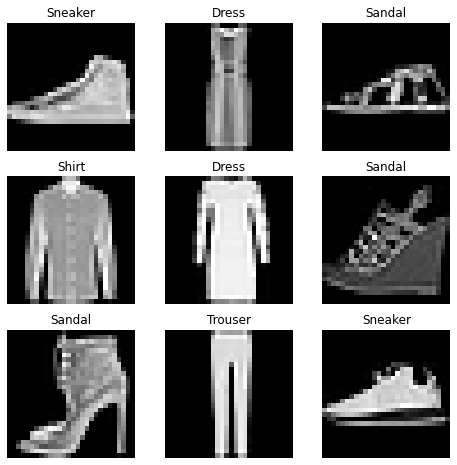

In [41]:
labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data),
                               size=(1,)).item()
    img, label = training_data[sample_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

##Creating a Custom Dataset for your files
A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.

If the FahsionMNIST images are stored in a direction `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

In [42]:
import os
import pandas as pd
from torchvision.io import read_image

In [43]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem(self, idx):
        img_path = os.path.join(self.img_dir,
                                self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

###`__init__`
The `__init__` function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms.

The labels.csv file looks like:
```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpy, 9
```

In [44]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file, 
                                  names=['file_name', 'label'])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

###`__len__`
the number of samples in the dataset

In [45]:
def __len__(self):
    return len(self.img_labels)

###`__getitem__`
The `__getitem__` function loads and returns a sample from the dataset at the given index `idx`.

Based on the index, it identifies the image's location on disk, converts that to a tensor using `read_image`, retrieves the corresponding label from the csv data in `self.img_labels`, calls the transform function on them (if applicable), and returns the tensor image and corresponding label in a tuple.

In [46]:
def __getitem__(self, idx):
    img_path = os.path_join(self.img_dir,
                            self.img_labels.iloc[idx,0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

##Preparing your data fro training with DataLoaders
The `Dataset` retrieves dataset's features and labels on sample at a time. While training a model, we typically want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity:

In [47]:
from torch.utils.data import DataLoader

In [48]:
train_dataloader = DataLoader(training_data, 
                              batch_size=64,
                              shuffle=True)
test_dataloader = DataLoader(test_dataloader,
                             batch_size=64,
                             shuffle=True)

##Iterate through the DataLoader
After loading the dataset into the `DataLoader`, we can iterate through the dataset as needed. Each iteration below returns a batch of `train_features` and `train_labels` (containing `batch_size=64` features and labels, respectively). `shuffle=True` means the data will be shuffled after we iterate all batches.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


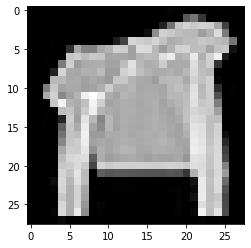

Label: 6


In [49]:
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

In [50]:
train_features[0].shape, train_features[0].squeeze().shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

#TRANSFORMS
The transforms are used to perform some manipulation of the data and make it suitable for training

All TorchVision datasets have two parameters - `transform` to modify the features and `target_transform` to modify the labels - that accept callables containing the transformation logic. The `torchvision.transforms` module offers several commony-used transforms out of the box.

The FahsionMNIST features are in PIL image format, and the labels are integers. For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors. To make these transformations, we use `ToTensor` and `Lambda`.

In [51]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [52]:
ds = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

##`ToTensor()`
`ToTensor` convets a PIL image or NumPy `ndarray` into a `FloatTensor`. and scales the image's pixel intensity values in the range [0., 1.].

##`Lambda` Transforms
Lambda transforms apply any user-defined lambda function.

Here, this lambda function turns the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in the dataset) and calls `scatter_` which assigns a `value=1` on the index as given by the label `y`.

In [54]:
target_transform=Lambda(lambda y: torch.zeros(10, 
                                              dtype=torch.float).scatter_(dim=0, 
                                                                         index=torch.tensor(y), value=1))

#BUILD THE NEURAL NETWORK
The `torch.nn` namespace provides all the building blocks we need to build neural network. Every module in PyTorch subclasses the `nn.Module`. A neutral network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architecturs easily.

The following sections are used to build a neural network to classify images in the FashionMNIST dataset.

In [55]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##Get Device for Training

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


##Define the Class
We define neural networks by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

In [57]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We can create an instance of `NeuralNetwork`, and move it to the `device`, and print its structure

In [58]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use this model, we pass it the input data. This executes the model's `forward`, along with some background operations. Do NOT call `model.forward()` directly!

Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class. We get the prediction probabilities by passing it through an instance of the `nn.Softmax` module.

In [59]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f'Predicted class: {y_pred}')

Predicted class: tensor([5])


##Model Layers
Sampling a minibatch of 3 images of size 28x28 and passing it through the network

In [60]:
input_image = torch.rand(3, 28, 28)
print(input_image.size())

torch.Size([3, 28, 28])


###`nn.Flatten`
We initialize the `nn.Flatten` layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch diemnsion (at `dim=0` is maintained).

In [61]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


###`nn.Linear`
The linear layer is a module that applies a linear transformation on the input using its stored weights and biases

In [62]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


###`nn.ReLU`
Non-linear activations are what create the complex mappings between the model's inputs and outputs. They are applied after linear transformations to introduce *nonlinearity*, helping neural networks learn a wide variety of phenomena.

In this model, we use `nn.ReLU` between linear layers, but there is other activations to introduce non-linearity as well.

In [63]:
print(f'Before ReLU: {hidden1}\n\n')
hidden1 = nn.ReLU()(hidden1)
print(f'After ReLU: {hidden1}')

Before ReLU: tensor([[ 0.7889,  0.5328, -0.0018, -0.1216, -0.1747, -0.3829, -0.0358,  0.4350,
          0.1056, -0.2802,  0.2850,  0.3303,  0.0785, -0.1400, -0.6018, -0.1225,
         -0.4183,  0.7909, -0.2178, -0.1577],
        [ 0.7021,  0.5299,  0.2109, -0.0539, -0.0485, -0.1843,  0.0015,  0.0556,
          0.1155, -0.2586,  0.4357,  0.1028, -0.2441, -0.3793, -0.5860, -0.5061,
         -0.3492,  0.6666,  0.0959,  0.0218],
        [ 0.4748,  0.7957, -0.0946, -0.0292, -0.0210, -0.2094,  0.2138,  0.4016,
         -0.2211, -0.6329,  0.3566,  0.1418,  0.0900,  0.1151, -0.5289, -0.2583,
         -0.3503,  0.8979, -0.1011,  0.0794]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.7889, 0.5328, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4350, 0.1056,
         0.0000, 0.2850, 0.3303, 0.0785, 0.0000, 0.0000, 0.0000, 0.0000, 0.7909,
         0.0000, 0.0000],
        [0.7021, 0.5299, 0.2109, 0.0000, 0.0000, 0.0000, 0.0015, 0.0556, 0.1155,
         0.0000, 0.4357, 0.1028, 0.0000, 0.0000, 0.00

###`nn.Sequential`
`nn.Sequential` is an ordered container of modules. The data is passed through all the modules in the same order as defined.

In [64]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20,10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

###`nn.Softmax`
The returned logits above contain raw values in [-infty, infty]. As we pass it through the `nn.Softmax` module, the logits are scaled to values [0,1] representing the model's predicted probabilities for each class. `dim` parameter indicates the dimension along which the values must sum to 1.

In [65]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

##Model Parameters
Many layers inside a neural network are *parameterized*, i.e. have associated weights and biases that are optimized during training. Subclassing `nn.Module` automatically tracks all fields defined inside the model object, and makes all parameters accessible using the model's `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and a preview of its valus:

In [66]:
print('Model structure: ', model, '\n\n')

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n')

Model structure:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0146, -0.0324,  0.0331,  ...,  0.0193, -0.0010,  0.0135],
        [ 0.0097,  0.0271, -0.0267,  ...,  0.0104, -0.0355, -0.0243]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([-0.0049,  0.0293], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0425,  0.0057, -0.0049,  ...,  0.0215, -0.0210,  0.0344],
        [-0.0002,  0.0283,  0.0427,  ...,  0.0087, -0.0025, -0.0117]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | S

#AUTOMATIC DIFFERENTIATION WITH `TORCH.AUTOGRAD`

In the backpropagation, parameters (model weights) are adjusted according to the **gradient** of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called `torch.autograd`. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input `x`, parameters `w` and `b`, and some loss function.

In [67]:
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In this network, `w` and `b` are parameters, which we need to optimize. Thus, we need to be able to compute the gradients of loss function with respect to those variables. In order to do that, we set the `requires_grad` property of those tensors.

You can set the value of `requires_grad` when creating a tensor, or later by using `x.requires_grad_(True)` method.

A function that we apply to tensors to construct computational graph is... in fact... an object of class `Function`. This object knows how to compute the function in the *forward* direction, and also now to compute its derivative during the *backward propagation* step. A reference to the backward propagation function is stored in `grad_fn` property of a tensor.

In [68]:
print('Gradient function for z =', z.grad_fn)
print('Gradient function for loss =', loss.grad_fn)

Gradient function for z = <AddBackward0 object at 0x7f7afedc59d0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f7afdd76150>


##Computing Gradients
To optimize weights of parameters in the neural network, we need to compute the derivatives of the loss function with respect to parameters. To compute those derivatives, we call `loss.backward()`, and then retrieve the values from `w.grad` and `b.grad`:

In [69]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0110, 0.3264, 0.2503],
        [0.0110, 0.3264, 0.2503],
        [0.0110, 0.3264, 0.2503],
        [0.0110, 0.3264, 0.2503],
        [0.0110, 0.3264, 0.2503]])
tensor([0.0110, 0.3264, 0.2503])


* We can only obtain the `grad` properties for the leaf nodes of the computational graph, which have `requires_grad` property set to `True`. For all other nodes in the graph, gradients will not be available.
* We can only perform gradient calculations using `backward` once on a given graph, for performance reasons. If we need to do several `backward` calls on the same graph, we need to pass `retain_graph=True` to the `backward` call.

##Disabling Gradient Tracking
By default, all tensors with `requires_grad=True` are tracking their computational history and support gradient computation.

There are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do `forward` computation through the network. We can stop tracking computations by surrounding the computation code with `torch.no_grad()` block:

In [70]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the `detach()` method on the tensor:

In [71]:
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


Reasons we may want to disable gradient tracking:
* To mark some parameters in neural network as **frozen parameters**. This is a very common scenario for finetuning a pretrained network
* To speed up computation when we are only doing forward pass, because computation on tensors that do not track gradients would be more efficient.

###More on Computational Graphs
Autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of `Function` objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, we can automatically compute the gradients using the chain rule.

In a `forward` pass, autograd does two things simultaneously:
* run the requested operation to compute a resulting tensor
* maintain the operation's gradient function in the DAG

The `backward` pass kicks off when `.backward()` is called on the DAG root. `autograd` then:
* computes the gradients from each `.grad_fn`,
* accumulates them in the respective tensor's `.grad` attribute,
* propagates all the way to theleaf tensors using the chain rule.

The graph is recreated from scratch, after each `.backward()` call, autograd starts populating a new graph. This is exactly what allows us to use control flow statements in the model, we can change the shape, size and operations at every iteration if needed.

#OPTIMIZING MODEL PARAMETERS


Training a model is an iterative process; in each iteration (called an epoch) the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters, and **optimizes** these parameters using gradient descent.

##Prerequisite Code

In [72]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [73]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [74]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

##Hyperparameters
Hyperparameters are adjustable parameters that let us control the model optimization process.

We define the following hyperparameters for training:
* **Number of Epochs** - the number times to iterate over the dataset
* **Batch Size** - the number of data samples propagated through the network before the parameters are updated
* **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [75]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

##Optimization Loop
Each epoch consists of two main parts:
* **Train Loop** - iterate over the training dataset and try to converge to optimal parameters
* **Validation/Test Loop** - iterate over the test dataset to check if model performance is improving 

##Loss Function
**Loss function** measures the degree of dissimlarity of obtained result to the target value, and it is the loss function that we want to minimize during training.

Common loss functions include `nn.MSELoss` (Mean Square Error) for regression tasks, and `nn.NLLLoss` (Negative Log Likelihood) for classification. `nn.CrossEntropyLoss` combines `nn.LogSoftmax` and `nn.NLLLoss`.

##Optimizer
**Optimization algorithms** define how the training process is performed. All optimization logic is encapsulated in the `optimizer` object.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.

In [76]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
* Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we expilictly zero them at each iteration.
* Backpropagate the prediction loss with a call to `loss.backward()`.
* Once having gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.

##Full Implementation

In [77]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):0.1f}%, Avg loss: {test_loss:>8f} \n')

We initialize the loss function and optimizer, and pass it to `train_loop` and `test_loop`.

In [78]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for i in range(epochs):
    print(f'Epoch {t+1}\n--------------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print('Done!')

Epoch tensor([3., 3., 3., 3., 3.], dtype=torch.float64)
--------------------------
loss: 2.301264 [    0/60000]
loss: 2.286018 [ 6400/60000]
loss: 2.262222 [12800/60000]
loss: 2.261820 [19200/60000]
loss: 2.247670 [25600/60000]
loss: 2.213701 [32000/60000]
loss: 2.227579 [38400/60000]
loss: 2.194950 [44800/60000]
loss: 2.178491 [51200/60000]
loss: 2.154064 [57600/60000]
Test Error: 
 Accuracy: 40.3%, Avg loss: 2.149404 

Epoch tensor([3., 3., 3., 3., 3.], dtype=torch.float64)
--------------------------
loss: 2.160049 [    0/60000]
loss: 2.146698 [ 6400/60000]
loss: 2.085106 [12800/60000]
loss: 2.109373 [19200/60000]
loss: 2.062184 [25600/60000]
loss: 1.985796 [32000/60000]
loss: 2.032762 [38400/60000]
loss: 1.950111 [44800/60000]
loss: 1.943331 [51200/60000]
loss: 1.881023 [57600/60000]
Test Error: 
 Accuracy: 56.9%, Avg loss: 1.879669 

Epoch tensor([3., 3., 3., 3., 3.], dtype=torch.float64)
--------------------------
loss: 1.908293 [    0/60000]
loss: 1.875548 [ 6400/60000]
loss: 1.7

#SAVE AND LOAD THE MODEL

In [79]:
import torch
import torchvision.models as models

##Saving and Loading Model Weights
PyTorch models store the learned parameters in an internal state dictionary, called `state_dict`. These can be persisted via the `torch.save` method:

In [80]:
model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

To load model weights, we need to create an instance of the same model first, and then load the parameters using `load_state_dict()` method.

In [81]:
model = models.vgg16() # we do not specify pretrain=True
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note: be sure to call `model.eval()` method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

##Saving and Loading Models with Shapes
When loading model weights, we needed to instantiate the model class first, because the class deinfes the structure of a network. We may want to save the structure of this class together with the model, in which we can pass `model` (and not `model.state_dict()`) to the saving function:

In [82]:
torch.save(model, 'model.pth')

Then we can load the model:

In [83]:
model = torch.load('model.pth')